In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import boto3
import sagemaker
import matplotlib.pyplot as plt
import os
import io
import sagemaker.amazon.common as smac # sagemaker common libary

### 1. Data preparation

In [7]:
ice_screen_df = pd.read_csv('datasets/IceCreamData.csv')
ice_screen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  500 non-null    float64
 1   Revenue      500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


In [160]:
x_column = ice_screen_df[['Temperature']]
y_column = ice_screen_df[['Revenue']]
x_y_columns = ice_screen_df[['Temperature', 'Revenue']]
x = np.array(x_column).astype('float32')
y = np.array(y_column).astype('float32')

In [161]:
# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [210]:
print('x_train {0}, x_teste {1}, y_train {2}, y_test {3}'.format(x_train.shape, x_test.shape, y_train.shape, x_test.shape))

x_train (400, 1), x_teste (100, 1), y_train (400, 1), y_test (100, 1)


### 2. SageMaker configuration

In [163]:
sagemaker_session = sagemaker.Session()

In [183]:
bucket = 'varsmetagen-dev-static' # bucket need to be created beforehand
prefix = 'teste/tania/linear_learner' # prefix is the subfolder within the bucket.

In [184]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::078345292105:role/service-role/AmazonSageMaker-ExecutionRole-20220519T180533


In [185]:
#study=((0.5,0),(0.75,0),(1.0,0),(1.25,0),(1.50,0),(1.75,0),(2.0,0),(2.25,1),(2.5,0),(2.75,1),(3.0,0),(3.25,1),(3.5,0),(4.0,1),(4.25,1),(4.5,1),(4.75,1),(5.0,1),(5.5,1))
#a = np.array(study).astype('float32')
#labels = a[:,1]
#buf = io.BytesIO()
#smac.write_numpy_to_dense_tensor(buf, a, labels)
#buf.seek(0)

### 3. Converts the train data to recordIO and uploads to S3

In [186]:
# Code below converts the data in numpy array format to RecordIO format
# This is one of the formats accepted by Sagemaker Linear Learner 
# the code below will create an in-memory byte array 
# When you write to in-memory byte arrays, it increments 1 every time you write to it
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, x_train, y_train.reshape(-1,))
buf.seek(0) 

0

In [187]:
# Code to upload RecordIO data to S3 to be accessed later for training
key = 'linear-train-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://varsmetagen-dev-static/teste/tania/linear_learner/train/linear-train-data


### 4. Converts the test data to recordIO and uploads to S3

In [188]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, x_test, y_test.reshape(-1,))
buf.seek(0) 

0

In [189]:
# Code to upload RecordIO data to S3 to be accessed later for testing
key = 'linear-test-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://varsmetagen-dev-static/teste/tania/linear_learner/test/linear-test-data


### 5. Setting the model

In [190]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [191]:
boto3.Session().region_name

'sa-east-1'

In [192]:
# Creates a reference to the linearLearner container image
# If you don't have to specify (hardcode) the region,it will get the current region name using boto3.Session
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)

In [193]:
# useful params:
# - use_spot_instances = True
# - max_run = 300
# - max_wait = 600)
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

In [194]:
# num_models: train 32 different versions of the model and will get the best out of them
# predictor_type: regressor, but could be other kind of predictor (classifier)
# epochs: how many times should pass through the data. After our entire training set is seen by the model, we say that one epoch is finished.
# mini_batch_size: means you only take a subset of all your data during one iteration.
# feature_dim: data dimension
# loss: Mean absolute error (MAE). https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3
linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 5,
                           num_models = 32,
                           loss = 'absolute_loss')

### 6. Trainning the model

In [195]:
# Now we are ready to pass in the training data from S3 to train the linear learner model
linear.fit({'train': s3_train_data})

2022-11-05 17:38:18 Starting - Starting the training job...
2022-11-05 17:38:44 Starting - Preparing the instances for trainingProfilerReport-1667669898: InProgress
.........
2022-11-05 17:40:08 Downloading - Downloading input data...
2022-11-05 17:40:44 Training - Downloading the training image.........
2022-11-05 17:42:14 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/05/2022 17:42:17 INFO 140670613550912] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_

In [199]:
# you can see the logs on CloudWatch log group aws/sagemaker/TrainingJobs

### 7. Deploy and test the model

In [200]:
# serializer:  encode data for an inference endpoint.
# deserializer: decode data from an inference endpoint.
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

In [201]:
# when the deploy is completed you will se --------! below this cell
linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge',
                                 serializer = CSVSerializer(),
                                 deserializer = JSONDeserializer())

--------!

In [202]:
result = linear_regressor.predict(x_test)

In [204]:
predictions = np.array([r['score'] for r in result['predictions']])

In [205]:
predictions

array([837.80114746, 678.12109375, 465.02120972, 375.78939819,
       357.74411011, 549.44488525, 392.84609985, 451.0668335 ,
       593.33508301, 581.70239258, 427.44708252, 455.39794922,
       622.10192871, 592.44995117, 871.0369873 , 264.52801514,
       677.1817627 , 651.96875   , 611.04663086, 482.61386108,
       695.51049805, 413.50927734, 369.80218506, 664.52905273,
       461.52102661, 508.48562622, 309.11785889, 587.86657715,
       326.84686279, 449.69076538, 532.6998291 , 368.41882324,
       676.47937012, 641.57775879, 206.76365662, 177.12945557,
       417.55047607, 326.87026978, 659.62487793, 622.42407227,
       559.11279297, 582.81628418, 762.86132812, 827.47021484,
       552.6697998 , 511.07598877, 501.20675659, 662.93237305,
       421.18395996, 263.38446045, 787.47119141, 530.45300293,
       453.9213562 , 757.28491211, 268.02600098, 730.91882324,
       644.76843262, 744.21240234, 404.15936279, 653.31396484,
       682.32666016, 646.20397949, 910.06408691, 473.81

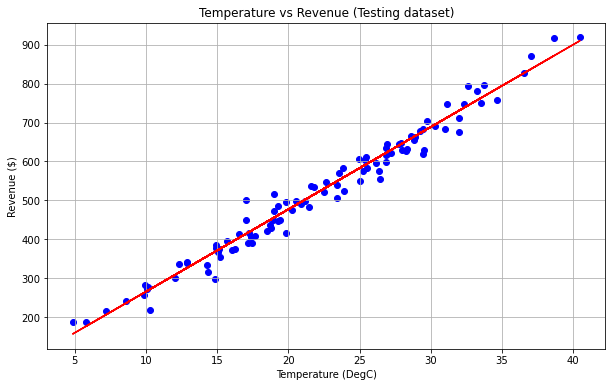

In [206]:
plt.figure(figsize = (10, 6))
plt.scatter(x_test, y_test, color = 'blue')
plt.plot(x_test, predictions, color = 'red')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Revenue ($)')
plt.title('Temperature vs Revenue (Testing dataset)')
plt.grid()

In [207]:
temperature = [[10]]
revenue = linear_regressor.predict(temperature)
print(revenue)

{'predictions': [{'score': 265.493408203125}]}


In [208]:
temperature = [[35]] 
revenue = linear_regressor.predict(temperature)
print(revenue)

{'predictions': [{'score': 794.281005859375}]}


### 8. Deleting the endpoint

In [212]:
# Delete the end-point
linear_regressor.delete_endpoint()